# Machine Learning Pipeline & Testing

### load libraries that will be used

In [95]:
# load and transform
from time import time
import zipfile
from datetime import datetime
import numpy as np
import pandas as pd

# ml
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn import metrics, feature_selection
from rank_metrics import ndcg_at_k
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.feature_selection import SelectKBest
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
#from sklearn.grid_search import GridSearchCV, RandomizedSearchCV

# graphics
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

# make figures better:
font = {'weight':'normal','size':20}
plt.rc('font', **font)
plt.rc('figure', figsize=(9.0, 6.0))
plt.rc('xtick.major', pad=10) # xticks too close to border!
plt.style.use('ggplot')

#print(plt.style.available)

### unzip and load data into memory

In [2]:
# Dataset #1: Countries to visit
zf = zipfile.ZipFile('data/countries.csv.zip')
df_countries = pd.read_csv(zf.open('countries.csv'))
print("df_countries => rows: %0.0f; columns: %0.0f" % np.shape(df_countries))

# Dataset #2: Compare demographic distributions within destination countries
zf = zipfile.ZipFile('data/age_gender_bkts.csv.zip')
df_country_demographics = pd.read_csv(zf.open('age_gender_bkts.csv'))
print("df_country_demographics => rows: %0.0f; columns: %0.0f" % np.shape(df_country_demographics))

# Dataset #3: User interactions on airbnb website
zf = zipfile.ZipFile('data/sessions.csv.zip')
df_user_sessions = pd.read_csv(zf.open('sessions.csv'))
print("df_user_sessions => rows: %0.0f; columns: %0.0f" % np.shape(df_user_sessions ))

# Dataset #4: Comparing test and training data to what has been provided as user data for 2015
# train
zf = zipfile.ZipFile('data/train_users_2.csv.zip')
df_train = pd.read_csv(zf.open('train_users_2.csv'))
print("df_train => rows: %0.0f; columns: %0.0f" % np.shape(df_train))

# test
zf = zipfile.ZipFile('data/test_users.csv.zip')
df_test = pd.read_csv(zf.open('test_users.csv'))
print("df_test => rows: %0.0f; columns: %0.0f" % np.shape(df_test))

df_countries => rows: 10; columns: 7
df_country_demographics => rows: 420; columns: 5
df_user_sessions => rows: 10567737; columns: 6
df_train => rows: 213451; columns: 16
df_test => rows: 62096; columns: 15


### combine, transform and engineer features

In [97]:
# concatenate train- and test users together in order to do all the changes on both datasets
df_users = pd.concat((df_train, df_test), axis=0, ignore_index=True)
print("df_users => rows: %0.0f; columns: %0.0f" % np.shape(df_users))

df_users => rows: 275547; columns: 16


In [98]:
# temporary -- use only a somple for testing purposes
#sample = np.random.choice(df_users.index.values, 1000, replace=False)
#df_users = df_users.ix[sample] 
#print("df_users => rows: %0.0f; columns: %0.0f" % np.shape(df_users))

In [99]:
### transformations ###

# incorrectly populated ages
av = df_users.age.values
df_users['age'] = np.where(np.logical_and(av>1900, av<2015), 2015-av, av) # fix those with year of birth as age
df_users['age'] = np.where(np.logical_or(av<14, av>100), np.nan, av) # set all ages deemed unlikely as null
mean_age = av.mean()
df_users['age'].fillna(mean_age, inplace=True)

# handling nulls 
df_users.replace("-unknown-", np.nan, inplace=True)
df_users.fillna(0, inplace=True)


### feature engineering ###

# date_account_created
df_users['date_account_created'] = pd.to_datetime(df_users.date_account_created)
df_users['year_account_created'] = df_users.date_account_created.dt.year
df_users['month_account_created'] = df_users.date_account_created.dt.month
df_users['week_account_created'] = df_users.date_account_created.dt.week
df_users['weekday_account_created'] = df_users.date_account_created.dt.weekday
df_users['day_account_created'] = df_users.date_account_created.dt.day

# timestamp_first_active
df_users['date_first_active'] = pd.to_datetime((df_users.timestamp_first_active // 1000000), format='%Y%m%d')
df_users['year_first_active'] = df_users.date_first_active.dt.year
df_users['month_first_active'] = df_users.date_first_active.dt.month
df_users['week_first_active'] = df_users.date_first_active.dt.week
df_users['weekday_first_active'] = df_users.date_first_active.dt.weekday
df_users['day_first_active'] = df_users.date_first_active.dt.day

# cleanup
# date_first_booking isn't populated in the test set so this feature can't be used 
# and I'm done with the orignal date fields
drop_list = ['date_account_created','timestamp_first_active','date_first_active','date_first_booking']
df_users.drop(drop_list, axis=1, inplace=True)

# One-hot-encoding features
ohe_features = ['gender', 'signup_method', 'signup_flow', 'language', 'affiliate_channel', 'affiliate_provider', 'first_affiliate_tracked', 'signup_app', 'first_device_type', 'first_browser']
for f in ohe_features:
    df_encodings = pd.get_dummies(df_users[f], prefix=f)
    df_users = df_users.drop([f], axis=1)
    df_users = pd.concat((df_users, df_encodings), axis=1)
    
    
### check impact of changes ###
print("df_users => observations: %0.0f; features: %0.0f" % np.shape(df_users))


### setup ml structure ###
le = LabelEncoder()
labels = df_users['country_destination'].values
y = le.fit_transform(labels) 
features = df_users.drop(['id','country_destination'], axis=1)

print("destination encoding:")
print(list(zip(le.classes_,range(0,len(y)))))

df_users => observations: 275547; features: 167
destination encoding:
[(0, 0), ('AU', 1), ('CA', 2), ('DE', 3), ('ES', 4), ('FR', 5), ('GB', 6), ('IT', 7), ('NDF', 8), ('NL', 9), ('PT', 10), ('US', 11), ('other', 12)]


### create scorer

In [100]:
# Simulate NDCG scorer used by Kaggle competition
def ndcg_wrapper(y_true,y_pred_proba):
    Y = np.fliplr(y_pred_proba.argsort())
      
    R = []
    NDCG = []
    for i in range(0,y_true.size):
        r = (Y[i,:]==y_true[i]).astype(int)
        R.append(r)
        NDCG.append(ndcg_at_k(r,5,method=1))
    return np.mean(NDCG)

ndcg_scorer = metrics.make_scorer(ndcg_wrapper, greater_is_better=True, needs_proba=True)

# output example
for i in range(0,5):
    print("Correct Destination in Position %d: NDGG = %.3f" % (i+1,ndcg_at_k([0]*i+[1],5,1)))

Correct Destination in Position 1: NDGG = 1.000
Correct Destination in Position 2: NDGG = 0.631
Correct Destination in Position 3: NDGG = 0.500
Correct Destination in Position 4: NDGG = 0.431
Correct Destination in Position 5: NDGG = 0.387


# Benchmark

In [101]:
# any of the algorithms built beyond this one should at the very least improve on this attempt 
Dummy = DummyClassifier(strategy='prior').fit(features, y)
dummy_score = ndcg_scorer(Dummy, features, y)

print('NDCG score for Dummy Estimator: {0:.4f}'.format(dummy_score))

NDCG score for Dummy Estimator: 0.7303


# Logistic Regression
First attempt: reduce problem to a binary analysis
* testing for NDF vs not-NDF gave me a lower score than the dummy classifier
    * prediction on training data: 0.692
    * prediction on test data: 0.693
  
| classification_report | precision | recall | f1-score | support
| :- | -- | -- | -- | -- |
| Non-NDF | 0.71 | 0.76 | 0.73 | 45490
| NDF | 0.67 | 0.61 | 0.64 | 37175
| avg / total | 0.69 | 0.69 | 0.69 | 82665

| Confusion_matrix | 
| :- | -- 
| 34502 | 10988 
| 14399 | 22776 

* testing for US vs non-US actually improved the calssification performance
    * prediction on training data: 0.776
    * prediction on test data: 0.771
  
| classification_report | precision | recall | f1-score | support
| :- | -- | -- | -- | -- |
| Non-US | 0.78 | 0.99 | 0.87 | 63664
| US | 0.52 | 0.04 | 0.08 | 19001
| avg / total | 0.72 | 0.77 | 0.69 | 82665

| Confusion_matrix | 
| :- | -- 
| 62933 | 731 
| 18219 | 782

In [129]:
# where the country is indicated as 'NDF'==8, 'US'=11
y_log  = np.where(y==11, 1, 0)
y_log.shape

(275547L,)

### test/train split
after the transfromations and feature engineering has been performed on the combination of the training and the test set, these two data sets are split out once more

In [130]:
# split train and test
X_train, X_test, y_train, y_test = train_test_split(
        features, y_log, test_size=0.3, random_state=0)

### Feature Scaling

Required by Logistic Regression

$x' = x - x_{min} / x_{max} - x_{min}$

In [131]:
X_train = MinMaxScaler().fit_transform(X_train)
y_train = MinMaxScaler().fit_transform(y_train)
X_test = MinMaxScaler().fit_transform(X_test)
y_test = MinMaxScaler().fit_transform(y_test)

print np.max(X_train), np.min(X_train), np.mean(X_train), np.max(y_train), np.min(y_train), np.mean(y_train)

C:\Miniconda\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Miniconda\lib\site-packages\sklearn\preprocessing\data.py:324: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\Miniconda\lib\site-packages\sklearn\preprocessing\data.py:359: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


1.0 0.0 0.0954876538575 1.0 0.0 0.224878423077


C:\Miniconda\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Miniconda\lib\site-packages\sklearn\preprocessing\data.py:324: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\Miniconda\lib\site-packages\sklearn\preprocessing\data.py:359: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


In [132]:
# create the linear model classifier
clf = LogisticRegressionCV()
# fit (train) the classifier
t0 = time()
print("training classifier")
clf.fit(X_train, y_train)
print "done in %0.3fs" % (time() - t0)
# print learned coeficients
print clf.coef_
print clf.intercept_

training classifier
done in 94.408s
[[  7.46369048e-01  -6.66137154e-01  -1.99638199e-01  -2.05718392e-01
   -9.33634112e-03  -1.59563979e-02  -5.34728381e-01  -1.99667241e-01
   -2.06819392e-01  -9.19315308e-03  -1.65536566e-02  -4.22925743e-01
    2.21830133e-01   1.93287128e-01   7.78662536e-03   2.86698511e-01
   -2.31976449e-01  -5.36593432e-02  -1.08457469e-03  -1.08052207e-01
   -1.18876333e-01   3.25684139e-02   2.09642033e-01  -2.03404153e-04
   -6.05683329e-03  -2.92366622e-03  -2.02595803e-02   1.77077291e-04
    1.12077960e-01  -1.79480170e-04  -7.95900371e-04  -2.25237037e-03
   -1.89038485e-03  -2.94470175e-03  -8.96548009e-02   1.75787228e-01
   -1.76184906e-01  -7.01860268e-05   5.90597179e-04  -1.84075927e-03
    7.30574543e-04   2.44048775e-03  -2.33982923e-03   1.43743116e-01
   -2.82723445e-02   1.02101976e-03  -2.70270058e-02  -2.66028582e-04
   -9.21821931e-04  -1.58778402e-03   1.87339310e-04  -3.56703769e-02
   -4.30031490e-03  -5.87147350e-03  -2.01457040e-03  

In [133]:
print("prediction...")
t0 = time()
y_train_pred = clf.predict(X_train)
print("prediction on training data: %0.3f" % clf.score(X_train, y_train))
print "done in %0.3fs" % (time() - t0)

print("prediction...")
t0 = time()
y_pred = clf.predict(X_test)
print("prediction on test data: %0.3f" % clf.score(X_test, y_test))
print "done in %0.3fs" % (time() - t0)

prediction...
prediction on training data: 0.776
done in 0.141s
prediction...
prediction on test data: 0.771
done in 0.062s


In [134]:
print metrics.classification_report(y_test, y_pred)
print metrics.confusion_matrix(y_test, y_pred)

             precision    recall  f1-score   support

        0.0       0.78      0.99      0.87     63664
        1.0       0.52      0.04      0.08     19001

avg / total       0.72      0.77      0.69     82665

[[62935   729]
 [18223   778]]


### Feature Selection
Select only the top 20% most important features using chi${^2}$ test

C:\Miniconda\lib\site-packages\sklearn\utils\validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(192882, 165)
(192882L, 33L)


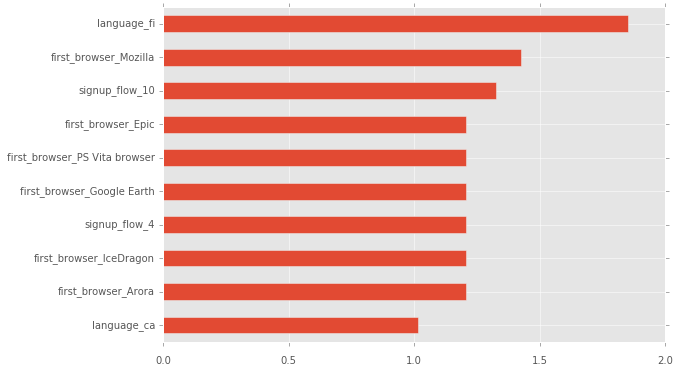

In [155]:
fs = feature_selection.SelectPercentile(feature_selection.chi2, percentile=20)
X_train_fs = fs.fit_transform(X_train, y_train)
#FeatureScores = pd.Series(index=X_train_fs.columns,data=X_train_fs.scores_).sort_values(ascending=False)
print X_train.shape
print X_train_fs.shape
FeatureScores = pd.Series(index=features.columns, data=fs.scores_).sort_values(ascending=True)
FeatureScores[:10].plot.barh();

# Decision Tree

### test/train split
after the transfromations and feature engineering has been performed on the combination of the training and the test set, these two data sets are split out once more

In [156]:
# split train and test
#cutt_off = df_train.shape[0]
#X_train, X_test, y_train, y_test = features[:cutt_off], features[cutt_off:], np.array(y[:cutt_off]),  np.array(y[cutt_off:])
X_train, X_test, y_train, y_test = train_test_split(
        features, y.reshape(-1, 1), test_size=0.3, random_state=0)

In [160]:
def measure_performance(X, y, clf, show_accuracy=True, show_classification_true=True, show_confussion_matric=True):
    y_pred = clf.predict(X)
    if show_accuracy:
        print "Accuracy:{0:.3f}".format(metrics.accuracy_score(y, y_pred)),"\n"
    if show_classification_true:   
        print "Classification report"
        print metrics.classification_report(y, y_pred),"\n"
    if show_confussion_matric:    
        print "Confussion matrix"
        print metrics.confusion_matrix(y, y_pred),"\n"

In [161]:
dt = tree.DecisionTreeClassifier(criterion='entropy')
t0 = time()
dt = dt.fit(X_train, y_train)
print "done in %0.3fs" % (time() - t0)
measure_performance(X_train, y_train, dt, show_accuracy=True, show_classification_true=True, show_confussion_matric=True)

done in 4.091s
Accuracy:0.965 

Classification report
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     43529
          1       0.96      0.95      0.95       375
          2       0.92      0.93      0.92      1006
          3       0.96      0.95      0.95       745
          4       0.92      0.93      0.93      1598
          5       0.93      0.93      0.93      3539
          6       0.93      0.93      0.93      1591
          7       0.93      0.90      0.92      1978
          8       0.94      0.99      0.96     87368
          9       0.98      0.90      0.94       518
         10       0.97      0.86      0.91       154
         11       0.99      0.90      0.94     43375
         12       1.00      0.86      0.92      7106

avg / total       0.97      0.96      0.96    192882


Confussion matrix
[[43529     0     0     0     0     0     0     0     0     0     0     0
      0]
 [    0   355     0     0     0     0     0   

In [163]:
t0 = time()
y_pred = dt.predict(X_test)
print "done in %0.3fs" % (time() - t0)
print "Accuracy:{0:.3f}".format(metrics.accuracy_score(y_test, y_pred)), "\n"
print metrics.classification_report(y_test, y_pred)
print metrics.confusion_matrix(y_test, y_pred)

done in 0.123s
Accuracy:0.617 

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     18567
          1       0.02      0.02      0.02       164
          2       0.01      0.01      0.01       422
          3       0.01      0.01      0.01       316
          4       0.02      0.02      0.02       651
          5       0.03      0.04      0.04      1484
          6       0.02      0.02      0.02       733
          7       0.02      0.02      0.02       857
          8       0.66      0.68      0.67     37175
          9       0.01      0.01      0.01       244
         10       0.00      0.00      0.00        63
         11       0.39      0.35      0.37     19001
         12       0.06      0.06      0.06      2988

avg / total       0.62      0.62      0.62     82665

[[18567     0     0     0     0     0     0     0     0     0     0     0
      0]
 [    0     3     5     1     4     8     1     3    70     1     1    57
     10]
 [  

### Impact of Feature Selection

In [164]:
t0 = time()
dt.fit(X_train_fs, y_train)
X_test_fs = fs.transform(X_test)
print "done in %0.3fs" % (time() - t0)
measure_performance(X_train_fs, y_train, dt, show_accuracy=True, show_classification_true=True, show_confussion_matric=True)

done in 1.416s
Accuracy:0.780 

Classification report
             precision    recall  f1-score   support

          0       0.77      0.96      0.85     43529
          1       0.66      0.53      0.59       375
          2       0.69      0.50      0.58      1006
          3       0.71      0.50      0.58       745
          4       0.67      0.47      0.55      1598
          5       0.71      0.50      0.59      3539
          6       0.74      0.48      0.58      1591
          7       0.71      0.46      0.56      1978
          8       0.78      0.86      0.82     87368
          9       0.88      0.39      0.54       518
         10       0.90      0.36      0.51       154
         11       0.82      0.58      0.68     43375
         12       0.96      0.36      0.52      7106

avg / total       0.79      0.78      0.77    192882


Confussion matrix
[[41932     0     0     0     1     2     0     0  1312     0     0   280
      2]
 [   30   198     0     0     0     1     0   

In [167]:
t0 = time()
y_pred_fs = dt.predict(X_test_fs)
print "done in %0.3fs" % (time() - t0)
print "Accuracy:{0:.3f}".format(metrics.accuracy_score(y_test, y_pred_fs)), "\n"
print metrics.classification_report(y_test, y_pred_fs)
print metrics.confusion_matrix(y_test, y_pred_fs)

done in 0.060s
Accuracy:0.572 

             precision    recall  f1-score   support

          0       0.71      0.89      0.79     18567
          1       0.00      0.00      0.00       164
          2       0.01      0.01      0.01       422
          3       0.01      0.01      0.01       316
          4       0.01      0.01      0.01       651
          5       0.03      0.02      0.03      1484
          6       0.02      0.01      0.01       733
          7       0.02      0.01      0.01       857
          8       0.62      0.69      0.65     37175
          9       0.02      0.01      0.01       244
         10       0.00      0.00      0.00        63
         11       0.39      0.27      0.32     19001
         12       0.06      0.03      0.04      2988

avg / total       0.53      0.57      0.55     82665

[[16449     3    18     7    11    49    24    18  1356     5     2   576
     49]
 [   14     0     1     3     2     8     2     4    81     0     0    39
     10]
 [  

# Random Forest

Characteristics:
* low bias
* high variance
* prone to overfitting

Tuning Parameters:
* number of trees
* number of features to consider at each split
* depth of trees

### Add more features 
In order to see whether adding session data makes a difference

In [ ]:
# sessions
sessions.rename(columns = {'user_id': 'id'}, inplace=True)